<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S6/blob/master/step%20of%205%20image%2C%20without%20L1%20L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:

import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             576
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09371662884950638 Batch_id=468 Accuracy=93.00: 100%|██████████| 469/469 [00:11<00:00, 41.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.02663998305797577 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:11<00:00, 39.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.05918292701244354 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:11<00:00, 41.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.05646923556923866 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:11<00:00, 40.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.04596524313092232 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.11276864260435104 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 45.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.04070926830172539 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:11<00:00, 39.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.03242649510502815 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.09319472312927246 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:11<00:00, 40.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.047168176621198654 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.013243104331195354 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:11<00:00, 39.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.025017207488417625 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 41.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.1263294368982315 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 38.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.07953452318906784 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 41.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.07230676710605621 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 40.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.09141693264245987 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 39.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9919/10000 (99.19%)

EPOCH: 16


Loss=0.017172226682305336 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:11<00:00, 40.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.07932555675506592 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 41.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.020107397809624672 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 41.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.003988558892160654 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 41.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.09383708983659744 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 40.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.01905154623091221 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 39.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.03362033888697624 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 23


Loss=0.00839388370513916 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH: 24


Loss=0.04143952205777168 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.0008524159784428775 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 26


Loss=0.06064996123313904 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.0034401218872517347 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 28


Loss=0.07410378009080887 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 40.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 29


Loss=0.005784099455922842 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.0005238453741185367 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 39.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 31


Loss=0.025443732738494873 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 40.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 32


Loss=0.008377432823181152 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 40.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 33


Loss=0.007213105913251638 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 34


Loss=0.025361627340316772 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 35


Loss=0.07213304936885834 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 36


Loss=0.012506474740803242 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 37


Loss=0.0648207888007164 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 40.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.09663046151399612 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 39


Loss=0.018377309665083885 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

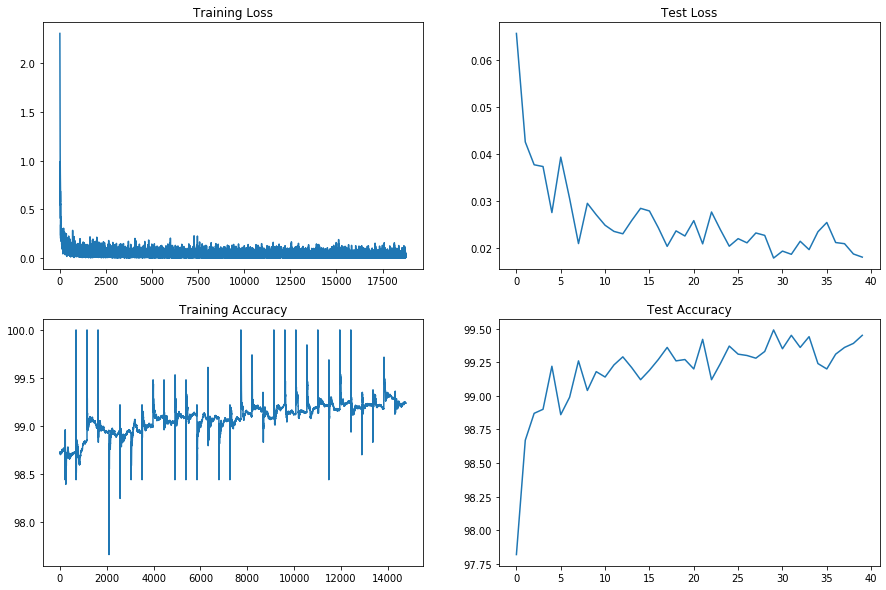

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

batchmates Mounika, Meenakshi, Vivek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


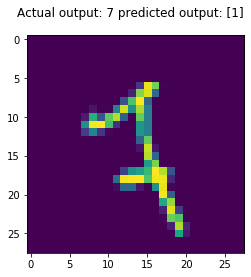

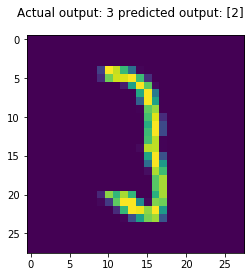

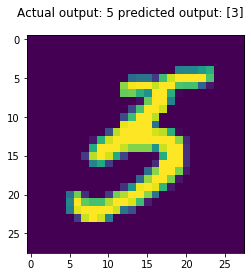

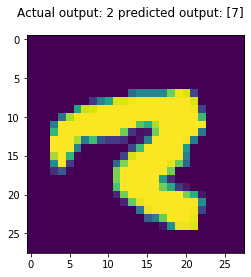

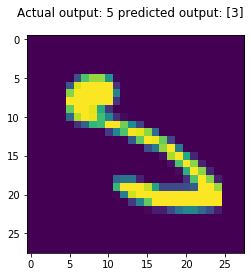

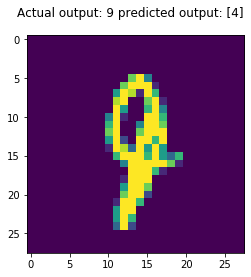

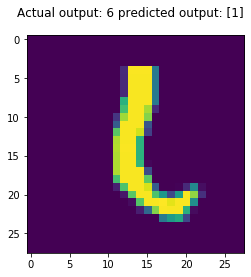

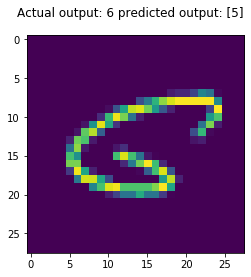

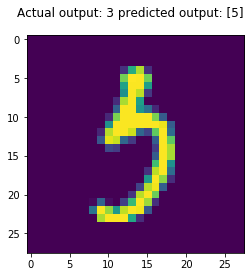

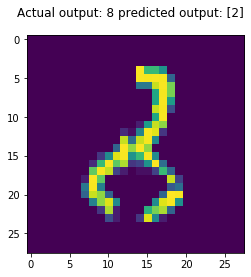

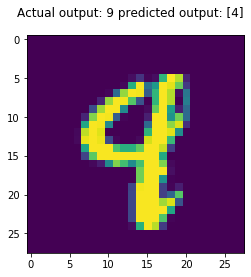

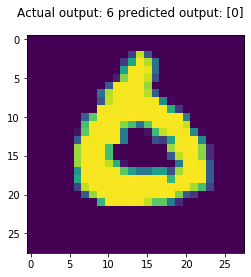

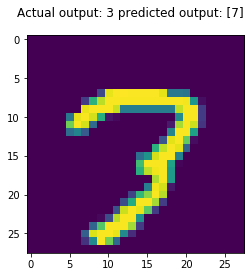

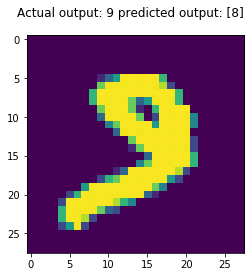

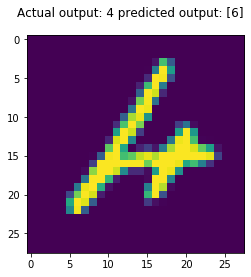

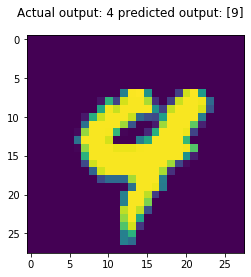

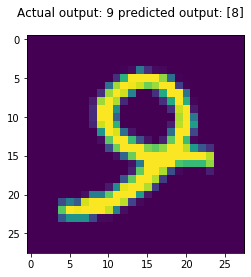

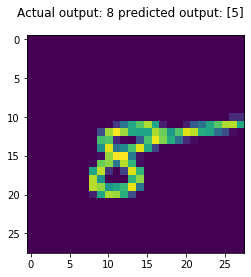

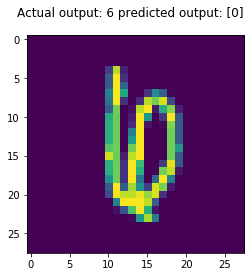

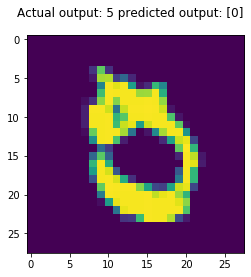

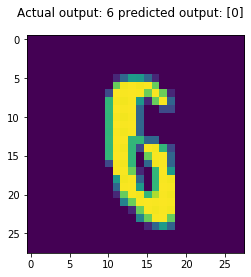

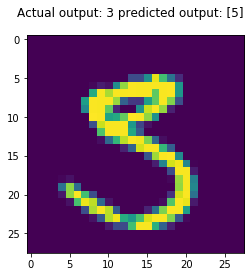

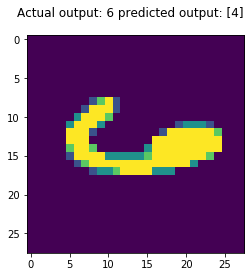

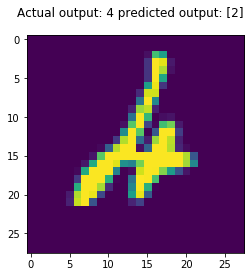

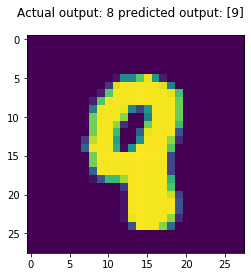

In [10]:
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim= True)
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " predicted output: " + str(predx[i]))

                count = count+1